In [ ]:
Bi LSTM Project

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LSTM
from keras.layers import Embedding, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
df = pd.read_csv('consumer_complaints.csv')
df.info()

C:\Users\VIGNESH M\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
date_received                   555957 non-null object
product                         555957 non-null object
sub_product                     397635 non-null object
issue                           555957 non-null object
sub_issue                       212622 non-null object
consumer_complaint_narrative    66806 non-null object
company_public_response         85124 non-null object
company                         555957 non-null object
state                           551070 non-null object
zipcode                         551452 non-null object
tags                            77959 non-null object
consumer_consent_provided       123458 non-null object
submitted_via                   555957 non-null object
date_sent_to_company            555957 non-null object
company_response_to_consumer    555957 non-null object
timely_response                 555957 non-null object
consumer_dis

In [7]:
x = df['product'].value_counts()
y = list(x.index)

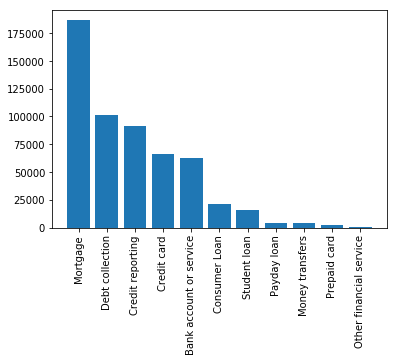

In [8]:
#df['product'].value_counts().sort_values(ascending=False)
plt.bar(y, x)
plt.xticks(rotation=90)
plt.show()

In [9]:
def print_plot(index):
    example = df[df.index == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_plot(321561)

Dear Sir 's or Madam : ( XX/XX/XXXX ) Several Months ago I received a letter from, Wells Fargo Home Mortgage, that I qualify for a rate reduction on my 6 % {$50000.00} Outstanding Mortgage of {$50000.00}, which I obtained from Wachovia Bank several years ago on my Co-Op Apartment, ( XXXX Bedroom/XXXX Bath's/etc ) ... 
I went to my local Branch Office of Wells-Fargo, and filled out papers asking for an Option to reduce my interest payments from 6 % to under 2.6 % on my outstanding mortgage andduring my several visits to different Wells-Fargo branches throughout XXXX, N.Y., I asked for information regarding my request to reduce the interest payments, which wouldhave saved me enough interest, to start paying down my principle ... 

Too make a long story short, nothing has happened, and every month that went by Iasked them for a decision ... When will Wells-Fargo reduce my interest of my Loan # XXXX, outstanding {$50000.00} Morgtgage Loan Originally from Wachovia Bank? 
I also complained, 

In [10]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].fillna(" ")


In [11]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = text.lower() # lowercase text
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('\d+', '')

In [30]:
###import nltk
###nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\VIGNESH
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
print_plot(321561)

ear ir adam everal onths ago received letter ells argo ome ortgage qualify rate reduction   utstanding ortgage  obtained achovia ank several years ago op partment edroom aths etc went local ranch ffice ellsargo filled papers asking ption reduce interest payments   outstanding mortgage andduring several visits different ellsargo branches throughout asked information regarding request reduce interest payments wouldhave saved enough interest start paying principle oo make long story short nothing happened every month went asked decision hen ellsargo reduce interest oan # outstanding  orgtgage oan riginally achovia ank also complained constantly called several moneylender whoare offering efinance mortgage frankly honestly believe namewas given moneylender people ellsargo generally hangup tell interested refinancing rate  + fee etc n opinion received several letter ecutive ortgage pecialist ustomer ecovery roup telling concerns important ellsargo promising theywill provide update research i

In [13]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58899 unique tokens.


In [14]:
print(word_index)

{'credit': 1, 'account': 2, 'would': 3, 'loan': 4, 'payment': 5, 'told': 6, 'nt': 7, 'debt': 8, 'report': 9, 'received': 10, 'information': 11, 'hey': 12, 'time': 13, 'called': 14, 'company': 15, 'card': 16, 'pay': 17, 'n': 18, 'mortgage': 19, 'e': 20, 'payments': 21, 'never': 22, 'call': 23, 'get': 24, 'sent': 25, 'bank': 26, 'paid': 27, 'letter': 28, 'back': 29, 'said': 30, 'could': 31, 'phone': 32, 'money': 33, 'ank': 34, 'made': 35, 'number': 36, 'amount': 37, 'due': 38, 'also': 39, 'asked': 40, 'home': 41, 'years': 42, 'still': 43, 'days': 44, 'balance': 45, 'since': 46, 'even': 47, 'month': 48, 'make': 49, 'late': 50, 'collection': 51, 'interest': 52, 'check': 53, 'hen': 54, 'months': 55, 'us': 56, 'help': 57, 'contacted': 58, 'day': 59, 'reporting': 60, 'times': 61, 'know': 62, 'date': 63, 'name': 64, 'one': 65, 'new': 66, 'service': 67, 'fees': 68, 'contact': 69, 'calls': 70, 'another': 71, 'stated': 72, 'like': 73, 'modification': 74, 'request': 75, 'accounts': 76, 'file': 77,

In [15]:
jj = tokenizer.texts_to_sequences("Welcome to ASN. Learn NLP with LSTM here.")
print(jj)

[[1952], [20], [1747], [1165], [7052], [], [20], [], [9170], [7052], [], [5327], [3932], [18], [], [], [1747], [20], [5327], [1956], [18], [], [18], [1747], [2894], [], [1952], [3875], [9170], [2261], [], [1747], [3932], [9170], [], [], [2261], [20], [1956], [20], []]


In [16]:
yy = pad_sequences(jj, maxlen=10)
print(yy)

[[   0    0    0    0    0    0    0    0    0 1952]
 [   0    0    0    0    0    0    0    0    0   20]
 [   0    0    0    0    0    0    0    0    0 1747]
 [   0    0    0    0    0    0    0    0    0 1165]
 [   0    0    0    0    0    0    0    0    0 7052]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0   20]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 9170]
 [   0    0    0    0    0    0    0    0    0 7052]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 5327]
 [   0    0    0    0    0    0    0    0    0 3932]
 [   0    0    0    0    0    0    0    0    0   18]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 1747]
 [   0    0    0    0    0    0    0    0    0   20]
 [   0    0    0    0    0    0    0    0    0

In [17]:
X = tokenizer.texts_to_sequences(df['consumer_complaint_narrative'].values)
#print(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (555957, 250)


In [18]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
Y = pd.get_dummies(df['product']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (555957, 11)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(500361, 250) (500361, 11)
(55596, 250) (55596, 11)


In [21]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3     # Due to time complexity I have given 1
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/3
7037/7037 [==============================] - 4304s 611ms/step - loss: 1.7442 - accuracy: 0.3708 - val_loss: 1.6577 - val_accuracy: 0.4011
Epoch 2/3
7037/7037 [==============================] - 4154s 590ms/step - loss: 1.6421 - accuracy: 0.4058 - val_loss: 1.6325 - val_accuracy: 0.4071
Epoch 3/3
7037/7037 [==============================] - 4259s 605ms/step - loss: 1.6213 - accuracy: 0.4109 - val_loss: 1.6303 - val_accuracy: 0.4079


In [22]:
model.save("model.h5")

In [23]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


1738/1738 [==============================] - 160s 92ms/step - loss: 1.6253 - accuracy: 0.4109
Test set
  Loss: 1.625
  Accuracy: 0.411


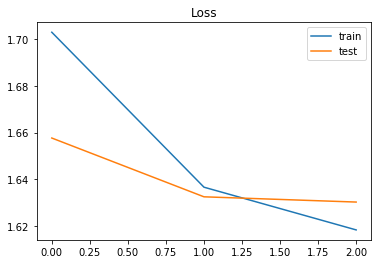

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


In [ ]:
##Installation

In [2]:
!pip install keras

In [7]:
!pip install tensorflow